In [29]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score,classification_report,pairwise_distances_argmin_min,silhouette_score, hamming_loss, f1_score, precision_score, recall_score, jaccard_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from preprocess_data import preprocess_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances,pairwise_distances
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.linear_model import SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [30]:
dataset_name = 'legal' # choose from 'imdb', 'academic_papers', 'legal', 'reviews', 'ecommerce'
data = preprocess_data(dataset_name)
#data['genre'].value_counts().plot(kind='bar')

In [31]:
if dataset_name == 'imdb' or dataset_name == 'academic_papers':
    data['num_genres'] = data['genre'].apply(len)
    data = data[data['num_genres'] == 1]
    
descriptions = data['description_processed'].tolist()
genres = data['genre'].apply(lambda x: x[0]).to_list() if dataset_name == 'academic_papers' else data['genre'].tolist() 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(genres)
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
X = model.encode(descriptions, show_progress_bar=True)

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Batches: 100%|██████████| 776/776 [14:07<00:00,  1.09s/it]


In [32]:
initial_train_size = 250
iterations = 20
uncertainty_threshold = 0.2
budget_per_iteration = 500
methods = ['random', 'entropy', 'margin', 'cluster', 'faiss_lsh']    


In [33]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_full_normalized = normalize(X_train_full, axis=1, norm='l2')
X_test_normalized = normalize(X_test, axis=1, norm='l2')
np.random.seed(42)
initial_indices = np.random.choice(len(X_train_full_normalized), initial_train_size, replace=False)

### Code for Non-random Centroid Initialization

In [34]:
# centroid_sentences = genre_descriptions = [
#     "intense physical confrontations fast paced sequences featuring combat explosions high stakes conflict",
#     "epic journeys heroic quests dangerous adventures often in fantastical settings exploration unknown",
#     "animated storytelling visual artistry non-human characters imaginative worlds surreal narratives",
#     "detailed accounts real-life individuals focusing on personal achievements significant historical moments",
#     "comedic scenarios witty dialogues humor-based interactions aimed at evoking laughter entertainment",
#     "depictions organized crime criminal behavior investigations heists underworld activities law enforcement",
#     "deep emotional narratives character evolution often dealing with life-altering events personal challenges",
#     "family-friendly themes focusing on relationships nurturing positive lessons designed for younger audiences",
#     "magical realms supernatural beings mystical adventures crossing boundaries between reality imagination",
#     "historical recreations focusing on pivotal events important eras real historical figures shaping world events",
#     "crafted to evoke fear suspense often involving supernatural forces psychological terror or extreme violence",
#     "stories centered around music performers musicians using songs as narrative devices to advance plot",
#     "musical storytelling with elaborate performances dance sequences centered around theatrical music numbers",
#     "intricate narratives involving crime detective work solving mysteries uncovering secrets unexpected twists",
#     "narratives centered on romantic relationships emotional intimacy personal growth often amidst challenges",
#     "explorations advanced technology futuristic societies space travel speculative science uncharted concepts",
#     "competitive sports athletic achievement depicting struggles victories focus on physical and mental endurance",
#     "psychological tension high stakes thrillers featuring danger suspense shocking revelations complex plots",
#     "military combat war strategies depictions battles focusing on heroism sacrifice wartime experiences",
#     "western frontier themes cowboys outlaws gunfights rugged landscapes lawlessness moral dilemmas"
# ]

# centroid_vecs = model.encode(centroid_sentences, show_progress_bar=True)
# centroid_vecs = normalize(centroid_vecs, axis=1, norm='l2')
# centroid_vecs = np.array(centroid_vecs)

In [35]:
# def sample_non_random_init(method, X_train, X_pool, remaining_indices, budget):
#     if method == 'random':
#         return np.random.choice(remaining_indices, budget, replace=False)
    
#     elif method == 'cluster':
#         num_clusters = 20
#         #clustering = faiss.Clustering(X_train.shape[1], num_clusters)
#         #clustering.verbose = False
#         #clustering.niter = 50
#         remaining_data = np.array([X_pool[i] for i in remaining_indices]).astype('float32')
#         #index_flat = faiss.IndexFlatIP(X_train.shape[1])
#         #index_flat.add(centroid_vecs.astype('float32'))
#         #clustering.train(remaining_data, index_flat)
#         #D, cluster_assignments = index_flat.search(remaining_data, 1)
#         #cluster_assignments = cluster_assignments.flatten()
#         #centroids = faiss.vector_to_array(clustering.centroids).reshape(num_clusters, X_train.shape[1])
#         kmeans = KMeans(n_clusters=num_clusters, init=centroid_vecs, n_init=1, max_iter=100)
#         kmeans.fit(remaining_data)
#         cluster_assignments = kmeans.labels_
#         final_centroids = kmeans.cluster_centers_

#         selected_indices = []
#         for cluster in range(num_clusters):
#             cluster_indices = [i for i, label in zip(remaining_indices, cluster_assignments) if label == cluster]
#             if cluster_indices:
#                 num_to_select_from_cluster = min((int((500/num_clusters)/2)), int(len(cluster_indices)/2))
#                 cluster_data = X_pool[np.array(cluster_indices)]
#                 cluster_center = final_centroids[cluster].reshape(1, -1)
#                 distances = np.linalg.norm(cluster_data - cluster_center, axis=1)
#                 #distances, _ = index_flat.search(cluster_center, len(cluster_indices))
#                 closest_samples = set([cluster_indices[i] for i in distances[0].argsort()[:num_to_select_from_cluster]])

#                 pairwise_distances_matrix = pairwise_distances(cluster_data)
#                 diversity_scores = pairwise_distances_matrix.mean(axis=1)
#                 most_diverse_indices = set([cluster_indices[i] for i in np.argsort(-diversity_scores)[:num_to_select_from_cluster]])
#                 selected_indices.extend(list(closest_samples.union(most_diverse_indices)))

#         return selected_indices

### Continue Here

In [36]:
def find_distant_points(distance_method, D_pool, sample_size):
    """
    Find the most distant points in the pool based on the specified distance method.

    Parameters:
    - distance_method (str): The method to compute distances ('min', 'max', 'avg').
    - D_pool (np.ndarray): Distance matrix.
    - sample_size (int): Number of samples to select.

    Returns:
    - furthest_indices_within_remaining (np.ndarray): Indices of the most distant points.
    """
    if distance_method == 'min':
        distances = D_pool.min(axis=1)
    elif distance_method == 'max':
        distances = D_pool.max(axis=1)
    else:
        distances = D_pool.mean(axis=1)

    furthest_indices_within_remaining = np.argsort(distances)[-sample_size:]

    return furthest_indices_within_remaining

In [37]:
def sample(method, X_train, X_pool, remaining_indices, budget, clf, index = None):
    if method == 'random':
        return np.random.choice(remaining_indices, budget, replace=False)
    
    elif method == 'margin':
        probs = clf.predict_proba(X_pool)
        sorted_probs = np.sort(probs, axis=1) 
        margins = sorted_probs[:, -1] - sorted_probs[:, -2]
        return np.argsort(margins)[:budget]  
    
    elif method == 'entropy':
        probs = clf.predict_proba(X_pool)
        entropies = -np.sum(probs * np.log(probs), axis=1)
        return np.argsort(entropies)[:budget]
    
    elif method == 'cluster':
        num_clusters = 20
        clustering = faiss.Clustering(X_train.shape[1], num_clusters)
        clustering.verbose = False
        clustering.niter = 50
        remaining_data = np.array([X_pool[i] for i in remaining_indices]).astype('float32')
        index_flat = faiss.IndexFlatIP(X_train.shape[1])
        clustering.train(remaining_data, index_flat)
        D, cluster_assignments = index_flat.search(remaining_data, 1)
        cluster_assignments = cluster_assignments.flatten()
        centroids = faiss.vector_to_array(clustering.centroids).reshape(num_clusters, X_train.shape[1])

        selected_indices = []
        for cluster in range(num_clusters):
            cluster_indices = [i for i, label in zip(remaining_indices, cluster_assignments) if label == cluster]
            if cluster_indices:
                num_to_select_from_cluster = min((int((500/num_clusters)/2)), int(len(cluster_indices)/3))
                cluster_data = X_pool[np.array(cluster_indices)]
                cluster_center = centroids[cluster].reshape(1, -1)
                distances, _ = index_flat.search(cluster_center, len(cluster_indices))
                closest_samples = [cluster_indices[i] for i in distances[0].argsort()[:num_to_select_from_cluster]]
                selected_indices.extend(closest_samples)

                pairwise_distances_matrix = pairwise_distances(cluster_data)
                diversity_scores = pairwise_distances_matrix.mean(axis=1)
                most_diverse_indices = set([cluster_indices[i] for i in np.argsort(-diversity_scores)[:num_to_select_from_cluster]])
                selected_indices.extend(most_diverse_indices)

                probs = clf.predict_proba(cluster_data)
                uncertainty = 1 - np.max(probs, axis=1)
                sorted_indices = np.argsort(-uncertainty)
                selected_cluster_indices = [cluster_indices[i] for i in sorted_indices[:num_to_select_from_cluster]]
                selected_indices.extend(selected_cluster_indices)
        return list(set(selected_indices))
    
    elif method == 'faiss_lsh':
        D_pool, _ = index.search(X_pool[remaining_indices], len(X_train))
        furthest_indices_within_remaining = find_distant_points('avg', D_pool, budget)
        return [remaining_indices[i] for i in furthest_indices_within_remaining]

In [38]:
acc_dict, f1_dict, prec_dict, rec_dict = {}, {}, {}, {}
for method in methods:
    print(f'Running active learning with {method} sampling')
    
    clf = SGDClassifier(loss='log_loss', random_state=42)
    accuracies, f1_scores, precs, recalls = [], [], [], []
    X_train = X_train_full_normalized[initial_indices]
    y_train = np.array(y_train_full)[initial_indices]
    remaining_indices = list(set(range(len(X_train_full_normalized))) - set(initial_indices))
    
    if method == 'faiss_lsh':
        ## IP index
        # index = faiss.IndexFlatIP(X_train_full_normalized.shape[1])

        ## LSH index
        nbits = 16  # Number of bits for hashing
        index = faiss.IndexLSH(X_train_full_normalized.shape[1], nbits)

        ## HNSW index
        # index = faiss.IndexHNSWFlat(X_train_full_normalized.shape[1], 32)

        index.add(X_train_full_normalized)

    for iteration in range(iterations):
        clf.partial_fit(X_train, y_train, classes=np.unique(y_train_full))
        y_pred = clf.predict(X_test_normalized)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        prec = precision_score(y_test, y_pred, average='macro')
        rec = recall_score(y_test, y_pred, average='macro')
        accuracies.append(acc)   
        f1_scores.append(f1)
        precs.append(prec)
        recalls.append(rec)
        
        print(f'Iteration {iteration + 1}/{iterations} - Accuracy: {acc}, F1: {f1}, Precision: {prec}, Recall: {rec}')
        if len(remaining_indices) == 0 or len(remaining_indices) < budget_per_iteration or len(X_train) >= len(X_train_full_normalized):
            break
        
        if method == 'faiss_lsh':
            selected_indices = sample(method, X_train, X_train_full_normalized, remaining_indices, budget_per_iteration, clf, index)
            index.add(X_train_full_normalized[selected_indices])
        else:
            selected_indices = sample(method, X_train, X_train_full_normalized, remaining_indices, budget_per_iteration, clf)
        X_train = np.vstack((X_train, X_train_full_normalized[selected_indices]))
        y_train = np.concatenate((y_train, np.array(y_train_full)[selected_indices]))
        remaining_indices = list(set(remaining_indices) - set(selected_indices))
        
    print(classification_report(y_test, y_pred))
    acc_dict[method] = accuracies
    f1_dict[method] = f1_scores
    prec_dict[method] = precs
    rec_dict[method] = recalls
        

Running active learning with random sampling
Iteration 1/20 - Accuracy: 0.3841193067311568, F1: 0.07228709331591479, Precision: 0.08320828667413213, Recall: 0.10455360400945228
Iteration 2/20 - Accuracy: 0.11608222490931076, F1: 0.04202807968757327, Precision: 0.10780498530778933, Recall: 0.10918042234777448


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

Iteration 3/20 - Accuracy: 0.494155582426441, F1: 0.07399277299857096, Precision: 0.14776032211516082, Recall: 0.10210976427631599
Iteration 4/20 - Accuracy: 0.4419588875453446, F1: 0.13293131453522594, Precision: 0.14704214957755016, Recall: 0.1486601139231197


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 5/20 - Accuracy: 0.42361950826279726, F1: 0.10594231266505331, Precision: 0.12357668249203746, Recall: 0.11645267839890275
Iteration 6/20 - Accuracy: 0.4592906086255542, F1: 0.10032866554026845, Precision: 0.12358885566382775, Recall: 0.11465486385328201


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 7/20 - Accuracy: 0.4465941152760983, F1: 0.11783400802733746, Precision: 0.15210331374138567, Recall: 0.12731257550155933
Iteration 8/20 - Accuracy: 0.4987908101571947, F1: 0.06721115143437464, Precision: 0.16660608508346797, Recall: 0.10015681104944718


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 9/20 - Accuracy: 0.47480854494155583, F1: 0.09937273609835078, Precision: 0.1749459739607389, Recall: 0.1158301562219961
Iteration 10/20 - Accuracy: 0.49798468359532444, F1: 0.0747243249243314, Precision: 0.1343233563377448, Recall: 0.1031656855563908


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 11/20 - Accuracy: 0.48024989923417977, F1: 0.1445903955492596, Precision: 0.2506499979407423, Recall: 0.146107121729048


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 12/20 - Accuracy: 0.4969770253929867, F1: 0.08220946586948866, Precision: 0.12682647246310846, Recall: 0.10610904201574214


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 13/20 - Accuracy: 0.4987908101571947, F1: 0.07604719388016176, Precision: 0.1367539468194893, Recall: 0.10368761982809147


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 14/20 - Accuracy: 0.49939540507859737, F1: 0.07389369168231874, Precision: 0.13196084817103543, Recall: 0.1029535208743235


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 15/20 - Accuracy: 0.49818621523579204, F1: 0.07975141014621503, Precision: 0.14939326211871143, Recall: 0.10507140745613994


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 16/20 - Accuracy: 0.4989923417976622, F1: 0.069453458108366, Precision: 0.10099299833662141, Recall: 0.1009538185928837


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 17/20 - Accuracy: 0.49919387343812976, F1: 0.07833575460184165, Precision: 0.11596772364475663, Recall: 0.10451707094311442


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 18/20 - Accuracy: 0.4977831519548569, F1: 0.07347435781285924, Precision: 0.17116759764700898, Recall: 0.10246366469512865


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 19/20 - Accuracy: 0.4977831519548569, F1: 0.07421606039581237, Precision: 0.14756513707952557, Recall: 0.10274249647414266


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

Iteration 20/20 - Accuracy: 0.4989923417976622, F1: 0.07491715703481125, Precision: 0.17398647762423633, Recall: 0.103040775691203
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.25      0.00      0.00       488
           2       0.00      0.00      0.00        23
           3       0.50      0.99      0.67      2477
           4       0.50      0.00      0.01       321
           5       0.00      0.00      0.00       198
           6       0.00      0.00      0.00       106
           7       0.17      0.00      0.01       432
           8       0.32      0.04      0.06       882
           9       0.00      0.00      0.00        16

    accuracy                           0.50      4962
   macro avg       0.17      0.10      0.07      4962
weighted avg       0.38      0.50      0.35      4962

Running active learning with entropy sampling
Iteration 1/20 - Accuracy: 0.3841193067311568, F1: 0.07228709331

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 3/20 - Accuracy: 0.44256348246674726, F1: 0.0966355209385413, Precision: 0.12832715937090794, Recall: 0.11022552238025822
Iteration 4/20 - Accuracy: 0.2214832728738412, F1: 0.05038057890772072, Precision: 0.08581546012752436, Recall: 0.10362921474466784


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 5/20 - Accuracy: 0.37182587666263606, F1: 0.14709716985736657, Precision: 0.20968263417465133, Recall: 0.14961391336897042
Iteration 6/20 - Accuracy: 0.41676743248690046, F1: 0.08879388817671549, Precision: 0.08713854917728968, Recall: 0.10835220596765124


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 7/20 - Accuracy: 0.4576783555018138, F1: 0.09556631607553082, Precision: 0.1109020201336608, Recall: 0.1103069678682826
Iteration 8/20 - Accuracy: 0.4917372027408303, F1: 0.07743371815625136, Precision: 0.08990721940214326, Recall: 0.10312424751939245


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 9/20 - Accuracy: 0.4629181781539702, F1: 0.09676996872692252, Precision: 0.18979227376218527, Recall: 0.11101228351808712


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 10/20 - Accuracy: 0.4822652156388553, F1: 0.09323653039549862, Precision: 0.15177388624475255, Recall: 0.1102110123899757


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 11/20 - Accuracy: 0.46795646916565903, F1: 0.09003739699021818, Precision: 0.11266398696173621, Recall: 0.10680723752950787


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 12/20 - Accuracy: 0.4804514308746473, F1: 0.08869019060105816, Precision: 0.11005450669585234, Recall: 0.11027956960148463


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 13/20 - Accuracy: 0.46473196291817814, F1: 0.09364706474522369, Precision: 0.11537409211557943, Recall: 0.1079988182903272


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 14/20 - Accuracy: 0.4866989117291415, F1: 0.08809035576702953, Precision: 0.1952566745154058, Recall: 0.1078079966923782


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 15/20 - Accuracy: 0.43833131801692865, F1: 0.10662120357613791, Precision: 0.1363410106786958, Recall: 0.11671715897136048


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 16/20 - Accuracy: 0.46634421604191856, F1: 0.09368298551030149, Precision: 0.12148842774099777, Recall: 0.10898171805648897


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 17/20 - Accuracy: 0.477428456267634, F1: 0.08400650741355765, Precision: 0.10027126956173085, Recall: 0.1049102344396096


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 18/20 - Accuracy: 0.4657396211205159, F1: 0.09958369260201366, Precision: 0.14274058646885068, Recall: 0.11275091364768278


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 19/20 - Accuracy: 0.4740024183796856, F1: 0.09155501415642839, Precision: 0.11315047627608407, Recall: 0.10797320488071516


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

Iteration 20/20 - Accuracy: 0.48810963321241435, F1: 0.08062085821644928, Precision: 0.18648679255966708, Recall: 0.104138014852407
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.14      0.01      0.01       488
           2       0.00      0.00      0.00        23
           3       0.51      0.95      0.66      2477
           4       0.50      0.00      0.01       321
           5       0.00      0.00      0.00       198
           6       0.00      0.00      0.00       106
           7       0.50      0.00      0.00       432
           8       0.22      0.08      0.12       882
           9       0.00      0.00      0.00        16

    accuracy                           0.49      4962
   macro avg       0.19      0.10      0.08      4962
weighted avg       0.38      0.49      0.35      4962

Running active learning with margin sampling
Iteration 1/20 - Accuracy: 0.3841193067311568, F1: 0.07228709331

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 2/20 - Accuracy: 0.09572752922208787, F1: 0.020911651944295284, Precision: 0.09550118985928151, Recall: 0.10045402395920014
Iteration 3/20 - Accuracy: 0.18903667875856509, F1: 0.05327313949222231, Precision: 0.09632997949647516, Recall: 0.10850977212853075


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 4/20 - Accuracy: 0.46110439338976217, F1: 0.08584941632306424, Precision: 0.10366132183292735, Recall: 0.10331255341326746
Iteration 5/20 - Accuracy: 0.4804514308746473, F1: 0.08830603706280028, Precision: 0.14262032126891808, Recall: 0.1093682732438221


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 6/20 - Accuracy: 0.4862958484482064, F1: 0.09031945388953455, Precision: 0.19604242352481596, Recall: 0.11052588298384594
Iteration 7/20 - Accuracy: 0.49677549375251917, F1: 0.09858155374751329, Precision: 0.2090056699814272, Recall: 0.11699274008651499


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 8/20 - Accuracy: 0.49375251914550583, F1: 0.08222332552549406, Precision: 0.10725107226868336, Recall: 0.10554070629224574


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 9/20 - Accuracy: 0.48810963321241435, F1: 0.09605819726118603, Precision: 0.21359230426815112, Recall: 0.11565009823982139


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 10/20 - Accuracy: 0.4580814187827489, F1: 0.1198277757646193, Precision: 0.21928459111387838, Recall: 0.12413605535196881


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 11/20 - Accuracy: 0.494155582426441, F1: 0.10883438984070004, Precision: 0.24623954214790564, Recall: 0.1204794445134368


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 12/20 - Accuracy: 0.49677549375251917, F1: 0.12522328258368148, Precision: 0.27835995523720053, Recall: 0.13211568311266916


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 13/20 - Accuracy: 0.501813784764208, F1: 0.08644165044189647, Precision: 0.4135370823145884, Recall: 0.10970622895210991


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 14/20 - Accuracy: 0.5008061265618702, F1: 0.09126955224612511, Precision: 0.26099559040762643, Recall: 0.11166408579964959


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 15/20 - Accuracy: 0.4951632406287787, F1: 0.10604881685820418, Precision: 0.26770382778720003, Recall: 0.12206345922187171


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 16/20 - Accuracy: 0.5022168480451431, F1: 0.09887623622656401, Precision: 0.302066693794635, Recall: 0.11494875737854102


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 17/20 - Accuracy: 0.5034260378879484, F1: 0.09491354296911086, Precision: 0.3131085639674687, Recall: 0.11398041426220795


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 18/20 - Accuracy: 0.4951632406287787, F1: 0.10990858744311369, Precision: 0.3071164017929481, Recall: 0.11997661381512473


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 19/20 - Accuracy: 0.5022168480451431, F1: 0.09763534044524504, Precision: 0.28080636591135033, Recall: 0.11584949549492982


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

Iteration 20/20 - Accuracy: 0.5012091898428053, F1: 0.08935375896953049, Precision: 0.29632920110192834, Recall: 0.11057202024806304
              precision    recall  f1-score   support

           0       1.00      0.05      0.10        19
           1       0.53      0.02      0.03       488
           2       0.00      0.00      0.00        23
           3       0.50      0.99      0.67      2477
           4       0.40      0.01      0.02       321
           5       0.00      0.00      0.00       198
           6       0.00      0.00      0.00       106
           7       0.19      0.01      0.01       432
           8       0.34      0.03      0.06       882
           9       0.00      0.00      0.00        16

    accuracy                           0.50      4962
   macro avg       0.30      0.11      0.09      4962
weighted avg       0.41      0.50      0.35      4962

Running active learning with cluster sampling
Iteration 1/20 - Accuracy: 0.3841193067311568, F1: 0.072287093

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 2/20 - Accuracy: 0.13643692059653365, F1: 0.0739250007303308, Precision: 0.10981062842970454, Recall: 0.20563673160679774


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 3/20 - Accuracy: 0.29181781539701734, F1: 0.07051826859819217, Precision: 0.108211060879382, Recall: 0.11357980709243001


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 4/20 - Accuracy: 0.3996372430471584, F1: 0.1095372217185467, Precision: 0.23537587366499174, Recall: 0.13288405033473955


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 5/20 - Accuracy: 0.33192261185006044, F1: 0.09368493763476123, Precision: 0.08625266904807025, Recall: 0.11568827582618746


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 6/20 - Accuracy: 0.4879081015719468, F1: 0.09598214659007984, Precision: 0.21850607567192828, Recall: 0.11421625586470326


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 7/20 - Accuracy: 0.496372430471584, F1: 0.09418968732361424, Precision: 0.17088239940457692, Recall: 0.11403331848240686


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 8/20 - Accuracy: 0.5008061265618702, F1: 0.0769152382420956, Precision: 0.1507649250893604, Recall: 0.10422585788529766


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 9/20 - Accuracy: 0.458484482063684, F1: 0.10575037513068264, Precision: 0.16711789168303495, Recall: 0.11638904772421106


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 10/20 - Accuracy: 0.41515517936316004, F1: 0.10832502870530707, Precision: 0.1444540749088458, Recall: 0.12038765370930682


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 11/20 - Accuracy: 0.4995969367190649, F1: 0.08045462267961594, Precision: 0.19004050405040504, Recall: 0.10620312661667489


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 12/20 - Accuracy: 0.4987908101571947, F1: 0.07250254706038234, Precision: 0.12147951905441205, Recall: 0.10231332808134228


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 13/20 - Accuracy: 0.49455864570737607, F1: 0.11123736833773176, Precision: 0.1712194640469673, Recall: 0.12087256266667072


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 14/20 - Accuracy: 0.5024183796856106, F1: 0.0799504062934047, Precision: 0.16581869153826687, Recall: 0.1058385999668279


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 15/20 - Accuracy: 0.5022168480451431, F1: 0.08796800172123864, Precision: 0.20890592670927396, Recall: 0.10954573285061822


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 16/20 - Accuracy: 0.5012091898428053, F1: 0.07795862677043428, Precision: 0.1352351239201392, Recall: 0.10465666778126655


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 17/20 - Accuracy: 0.5006045949214026, F1: 0.07297553131523747, Precision: 0.1871288729813062, Recall: 0.10249135003258183


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 18/20 - Accuracy: 0.4983877468762596, F1: 0.09402233441697376, Precision: 0.16873768672754716, Recall: 0.11257695698795736


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 19/20 - Accuracy: 0.4977831519548569, F1: 0.08456996504352692, Precision: 0.1687493780475669, Recall: 0.10748250667600608


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 20/20 - Accuracy: 0.5024183796856106, F1: 0.07820695139511459, Precision: 0.24849112580801855, Recall: 0.10500059363702674


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.45      0.01      0.02       488
           2       0.00      0.00      0.00        23
           3       0.50      0.99      0.67      2477
           4       0.60      0.01      0.02       321
           5       0.00      0.00      0.00       198
           6       0.00      0.00      0.00       106
           7       0.50      0.00      0.01       432
           8       0.43      0.04      0.07       882
           9       0.00      0.00      0.00        16

    accuracy                           0.50      4962
   macro avg       0.25      0.11      0.08      4962
weighted avg       0.45      0.50      0.35      4962

Running active learning with faiss_lsh sampling
Iteration 1/20 - Accuracy: 0.3841193067311568, F1: 0.07228709331591479, Precision: 0.08320828667413213, Recall: 0.10455360400945228


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 2/20 - Accuracy: 0.12978637646110439, F1: 0.04755791897654453, Precision: 0.21955886079970685, Recall: 0.10801388190901043


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 3/20 - Accuracy: 0.4921402660217654, F1: 0.07192644002635572, Precision: 0.08251873925409989, Recall: 0.10132180396901544


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 4/20 - Accuracy: 0.4157597742845627, F1: 0.1020093669167436, Precision: 0.2050355533704543, Recall: 0.12355658976454928


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 5/20 - Accuracy: 0.3264812575574365, F1: 0.08507625854265022, Precision: 0.11506934628916973, Recall: 0.11116314625113728


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 6/20 - Accuracy: 0.32567513099556633, F1: 0.0895512484798194, Precision: 0.0973749229383721, Recall: 0.11526251993789875


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 7/20 - Accuracy: 0.2984683595324466, F1: 0.07968662354379086, Precision: 0.11860734172952195, Recall: 0.11154059281108457


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 8/20 - Accuracy: 0.39439742039500203, F1: 0.10860220408222834, Precision: 0.10695285310881993, Recall: 0.12227949819778838


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 9/20 - Accuracy: 0.47702539298669894, F1: 0.10566866032915803, Precision: 0.1499710654274087, Recall: 0.11694398314291503


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 10/20 - Accuracy: 0.4248286981056026, F1: 0.10391734260946692, Precision: 0.14827258671434457, Recall: 0.11974952917522094


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 11/20 - Accuracy: 0.49334945586457074, F1: 0.08423265631810697, Precision: 0.14113897354720156, Recall: 0.10741687347990021


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 12/20 - Accuracy: 0.49677549375251917, F1: 0.078100093292917, Precision: 0.0760199745006375, Recall: 0.1041880081328723


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 13/20 - Accuracy: 0.4925433293027005, F1: 0.08924807037391311, Precision: 0.15717328965797286, Recall: 0.10865229711570981


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 14/20 - Accuracy: 0.4995969367190649, F1: 0.07116076803640521, Precision: 0.19653884653884654, Recall: 0.10178178958517214


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 15/20 - Accuracy: 0.5, F1: 0.06961604292687087, Precision: 0.14707907464322303, Recall: 0.10123918365756153


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 16/20 - Accuracy: 0.4977831519548569, F1: 0.08711230961990821, Precision: 0.18258218882986682, Recall: 0.10839907460436957


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 17/20 - Accuracy: 0.49919387343812976, F1: 0.08411061289985582, Precision: 0.22830564784053156, Recall: 0.10724839487687796


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 18/20 - Accuracy: 0.4951632406287787, F1: 0.08256115252029253, Precision: 0.21712576457680172, Recall: 0.10620461687740264


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 19/20 - Accuracy: 0.49818621523579204, F1: 0.07159948426619904, Precision: 0.14708068119435938, Recall: 0.10170660535146714


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 20/20 - Accuracy: 0.5014107214832729, F1: 0.0796642356758861, Precision: 0.14304270795370633, Recall: 0.1053920625846158
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.34      0.02      0.04       488
           2       0.00      0.00      0.00        23
           3       0.51      0.98      0.67      2477
           4       0.00      0.00      0.00       321
           5       0.00      0.00      0.00       198
           6       0.00      0.00      0.00       106
           7       0.22      0.00      0.01       432
           8       0.36      0.05      0.08       882
           9       0.00      0.00      0.00        16

    accuracy                           0.50      4962
   macro avg       0.14      0.11      0.08      4962
weighted avg       0.37      0.50      0.35      4962



/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

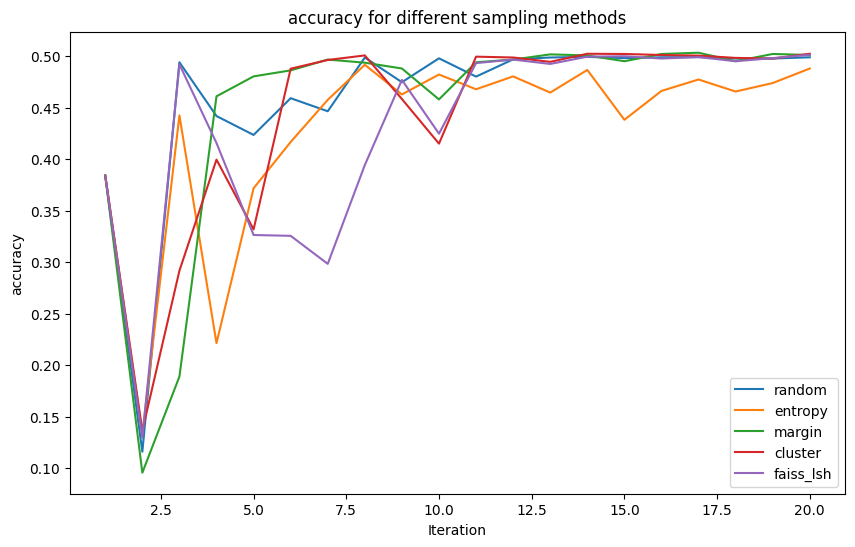

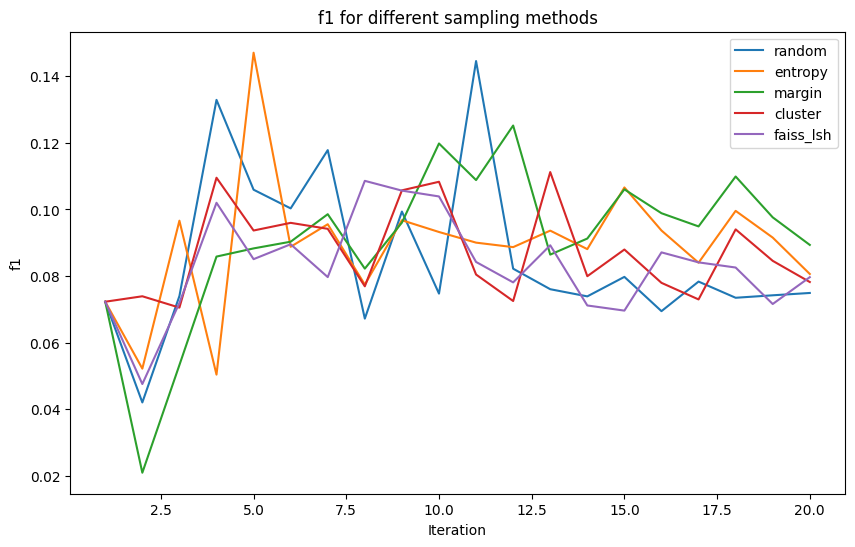

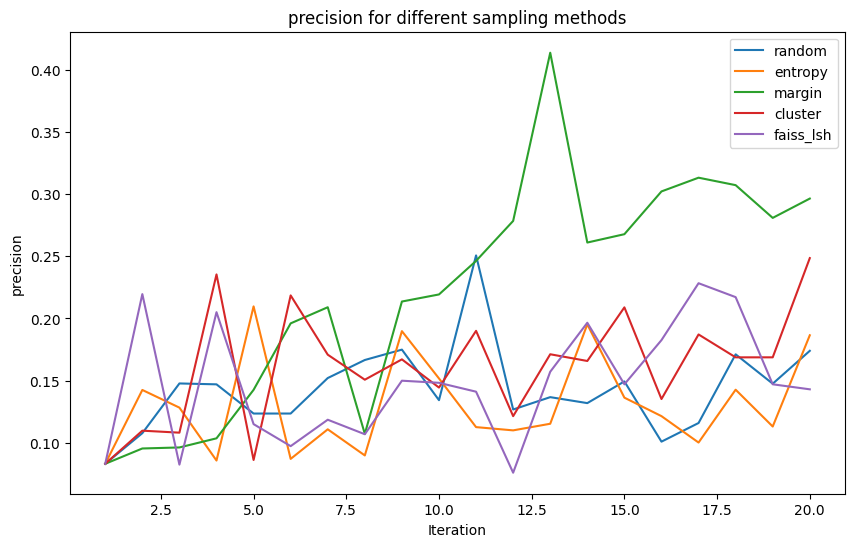

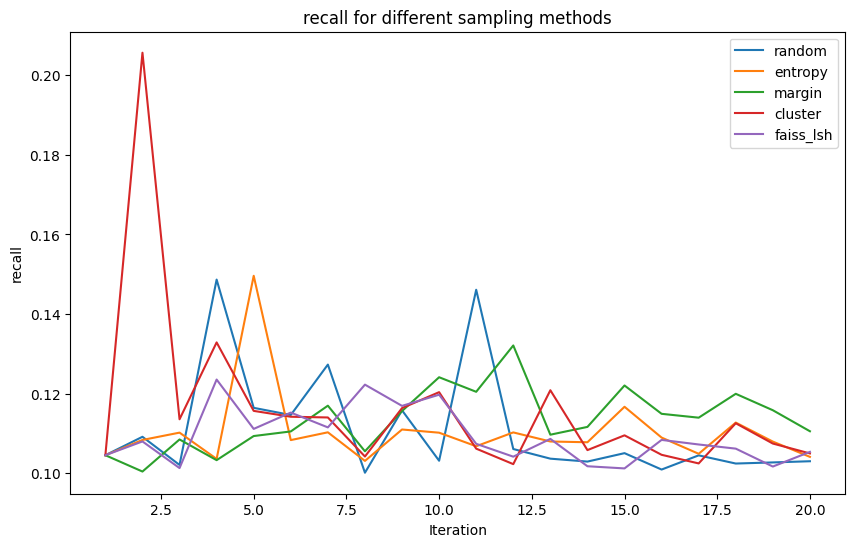

In [39]:

dics = {'accuracy': acc_dict, 'f1': f1_dict, 'precision': prec_dict, 'recall': rec_dict}
its = np.arange(1, iterations + 1)
for metric, dic in dics.items():
    plt.figure(figsize=(10, 6))
    for name, values in dic.items():
        sns.lineplot(x=its, y=values, label=name)
    plt.xlabel('Iteration')
    plt.ylabel(metric)
    plt.title(f'{metric} for different sampling methods')
    plt.legend()
    # plt.savefig(f'images/{dataset_name}_{metric}_active_learning.png')
    plt.savefig(f'../data/images/{dataset_name}_{metric}_active_learning.png')
    plt.show()
 
